In [93]:
from scipy.interpolate import UnivariateSpline, lagrange

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib notebook

In [10]:
x = np.arange(0,10,0.5)
y = np.sin(x)

In [99]:
x_new = np.arange(0,x[-1],0.1)
y_new = np.sin(x_new)

In [94]:
f = UnivariateSpline(x,y, s=0)
f_lagrange = lagrange(x,y)

<IPython.core.display.Javascript object>


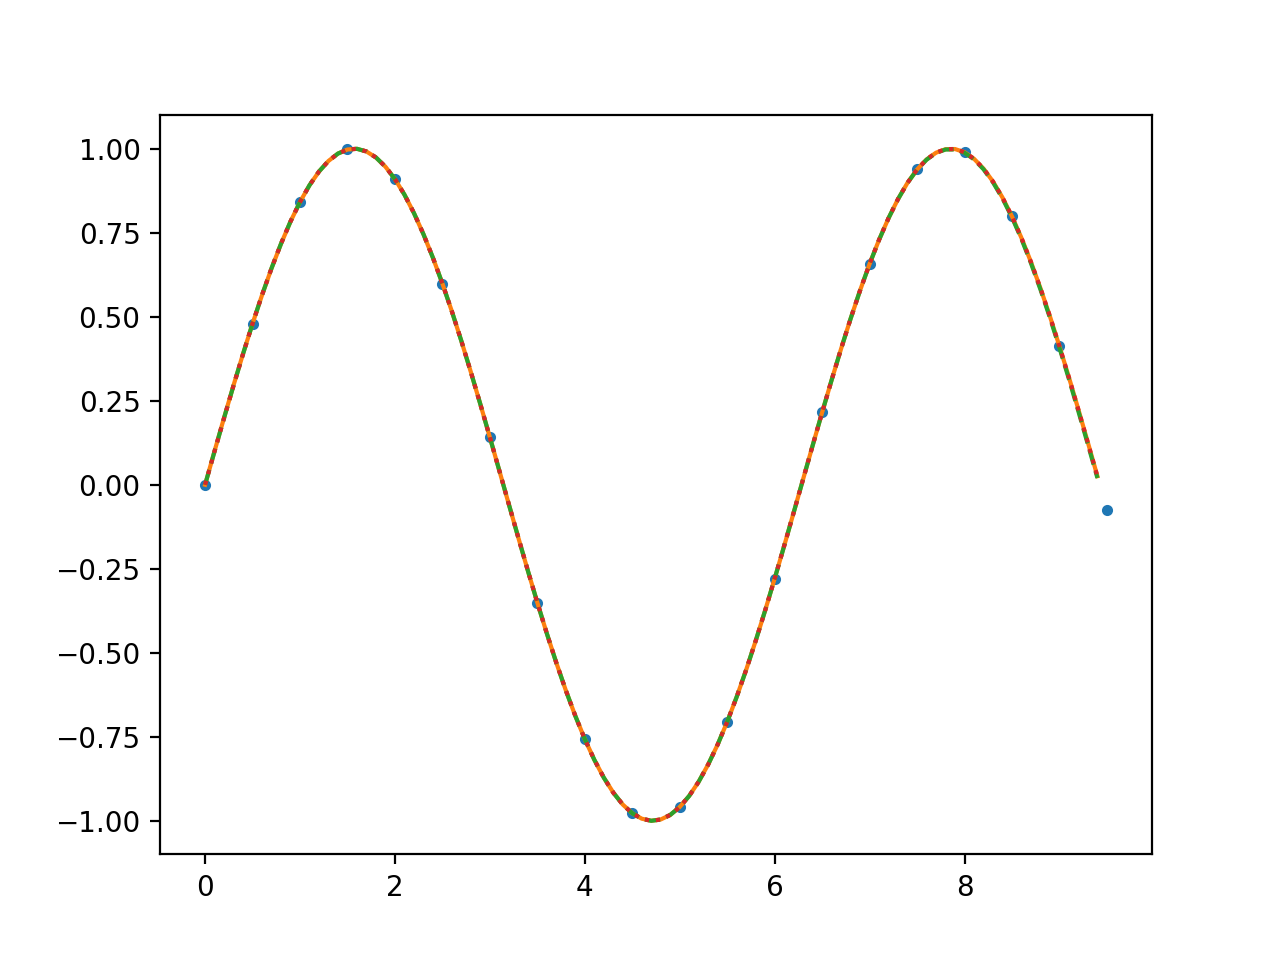

In [101]:
plt.plot(x,y,".")
plt.plot(x_new, f(x_new))
plt.plot(x_new, f_lagrange(x_new),"--")
plt.plot(x_new, y_new,":")

/home/adb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


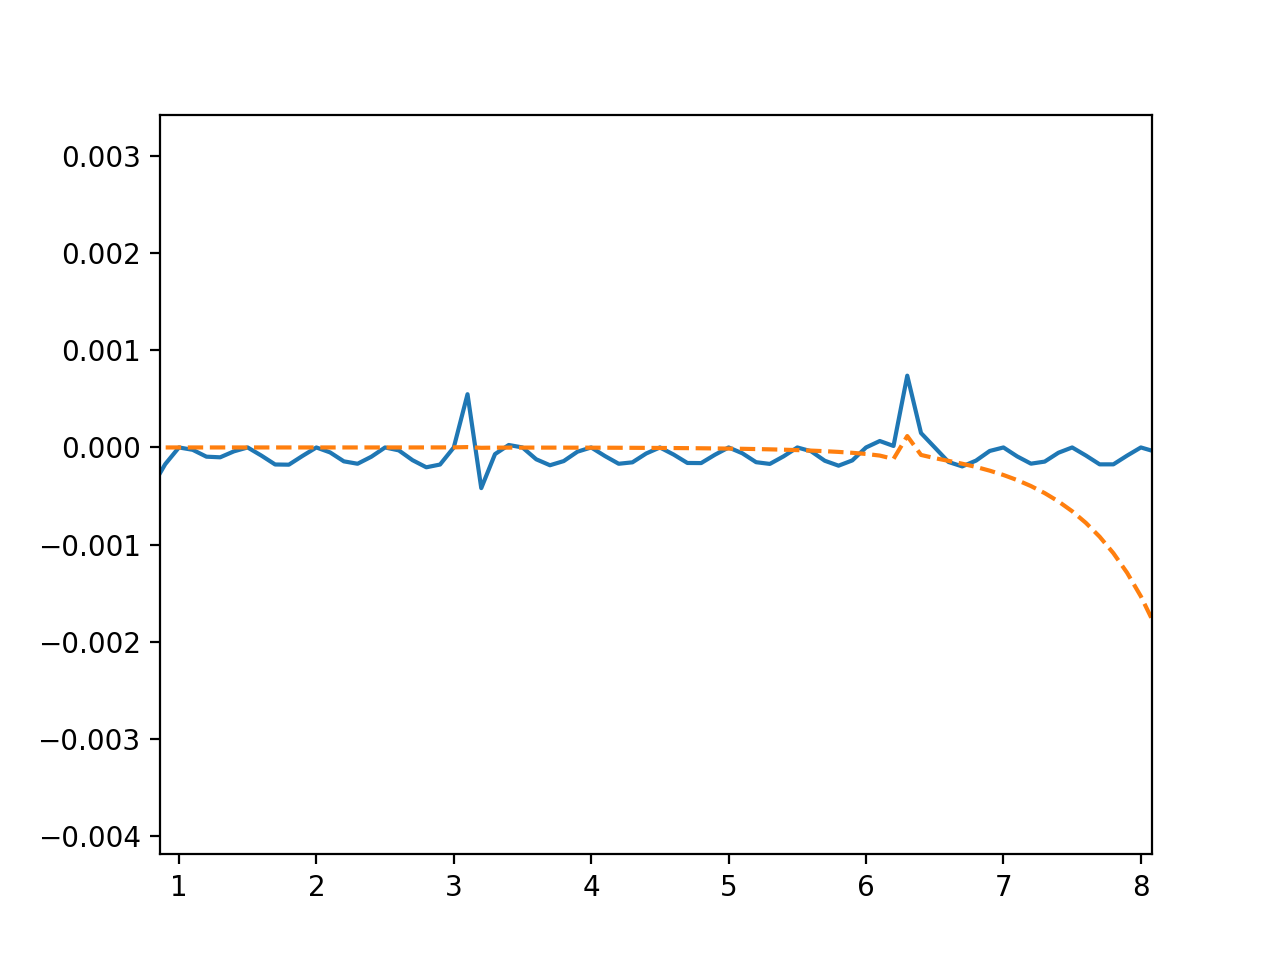

/home/adb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [102]:
plt.plot(x_new, (f(x_new)-y_new)/y_new)
plt.plot(x_new, (f_lagrange(x_new)-y_new)/y_new,"--")

In [30]:
f.get_coeffs()

array([ 8.60663864e-19,  3.36800637e-01,  8.23365388e-01,  1.03987043e+00,
        9.47996554e-01,  6.23927915e-01,  1.47124652e-01, -3.65706473e-01,
       -7.88998127e-01, -1.01911599e+00, -9.99718618e-01, -7.35555186e-01,
       -2.91302591e-01,  2.24272560e-01,  6.84932280e-01,  9.77917913e-01,
        1.03139593e+00,  7.66398502e-01,  2.60203721e-01, -7.51511205e-02])

In [28]:
x.shape

(20,)

In [5]:
def diss_profile(P, T, A_0, alpha, beta, gamma):
    
    # Dissociated Abundance
    log_A_d = alpha * np.log10(P) + beta/T + gamma
    A_d = 10.**log_A_d
    
    # Combine dissociated abundance with original abundance
    return (1/np.sqrt(A_0) + 1/np.sqrt(A_d))**-2

In [30]:
t_p = [[2560.647,0.942019],
[2490.566,0.7072062],
[2361.186,0.40337303],
[2328.841,0.32923782],
[2371.9678,0.2300741],
[2517.5203,0.16270982],
[2695.4177,0.12660892],
[2997.3047,0.061827302],
[3072.7764,0.044250116],
[3148.248,0.0294795],
[3223.7197,0.0229388],
[3309.9731,0.011891236],
[3336.9272,0.008017164],
[3374.663,0.0056024594],
[3455.5256,0.003732368],
[3487.8706,0.0023704886],
[3514.8247,0.0015419399],
[3520.2156,0.0010395879],
[3498.6523,6.0729287E-4],
[3455.5256,3.5902378E-4],
[3407.008,2.3076222E-4],
[3347.709,1.4310078E-4],
[3299.1914,1.0489439E-4]]


In [31]:
t,p = np.array(t_p).T

<IPython.core.display.Javascript object>


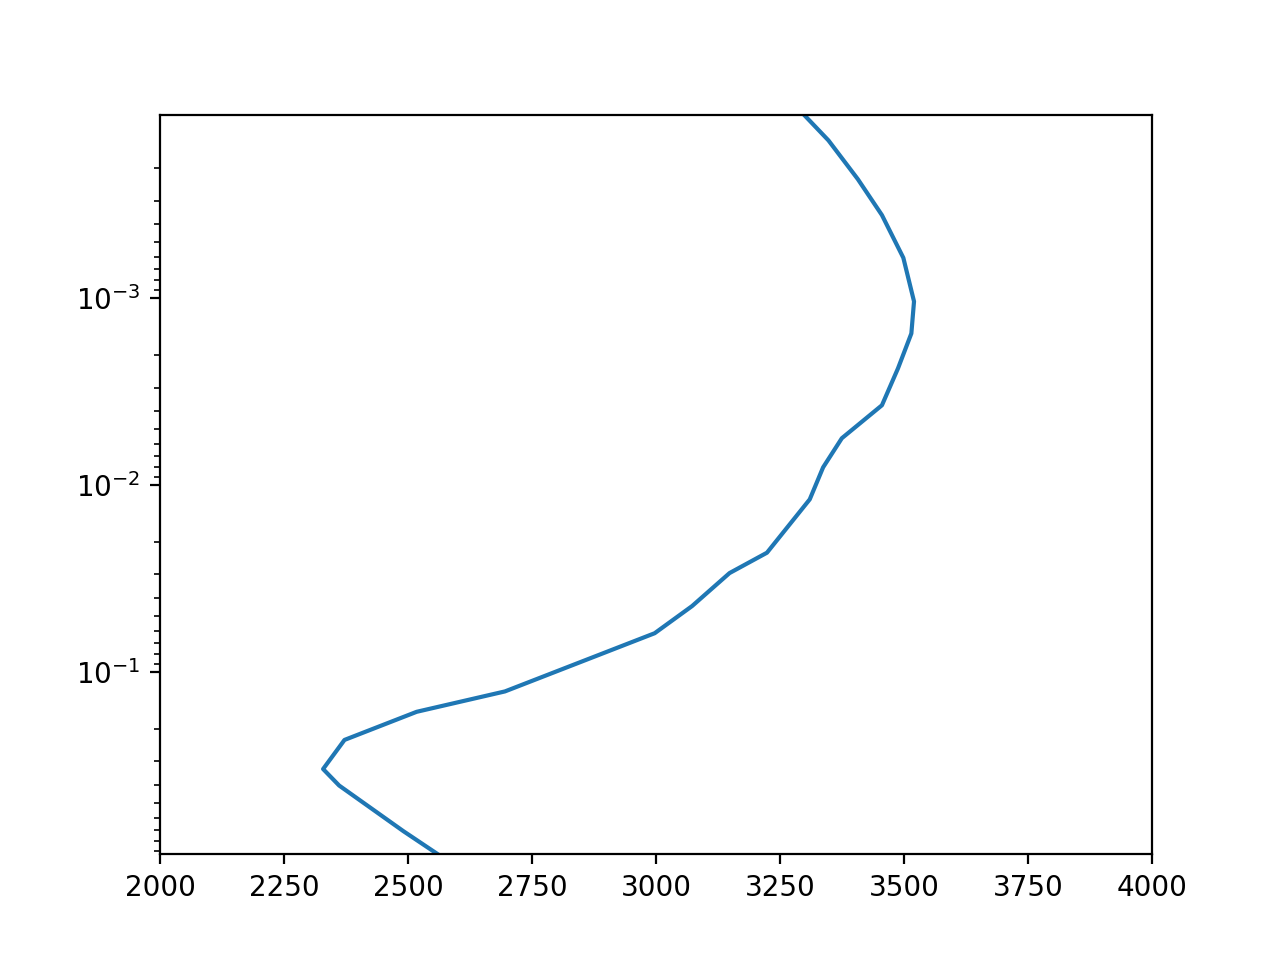

(2000, 4000)

In [8]:
plt.semilogy(t,p)
plt.ylim(p[0],p[-1])
plt.xlim(2000,4000)

In [47]:
p = 10**(np.linspace(2,-6,100))
t=np.ones(p.shape) * 3000
h2o = diss_profile(p,t,10**-3.3, 2,4.e-4,15.9)

In [46]:
plt.loglog(h2o,p)

<IPython.core.display.Javascript object>


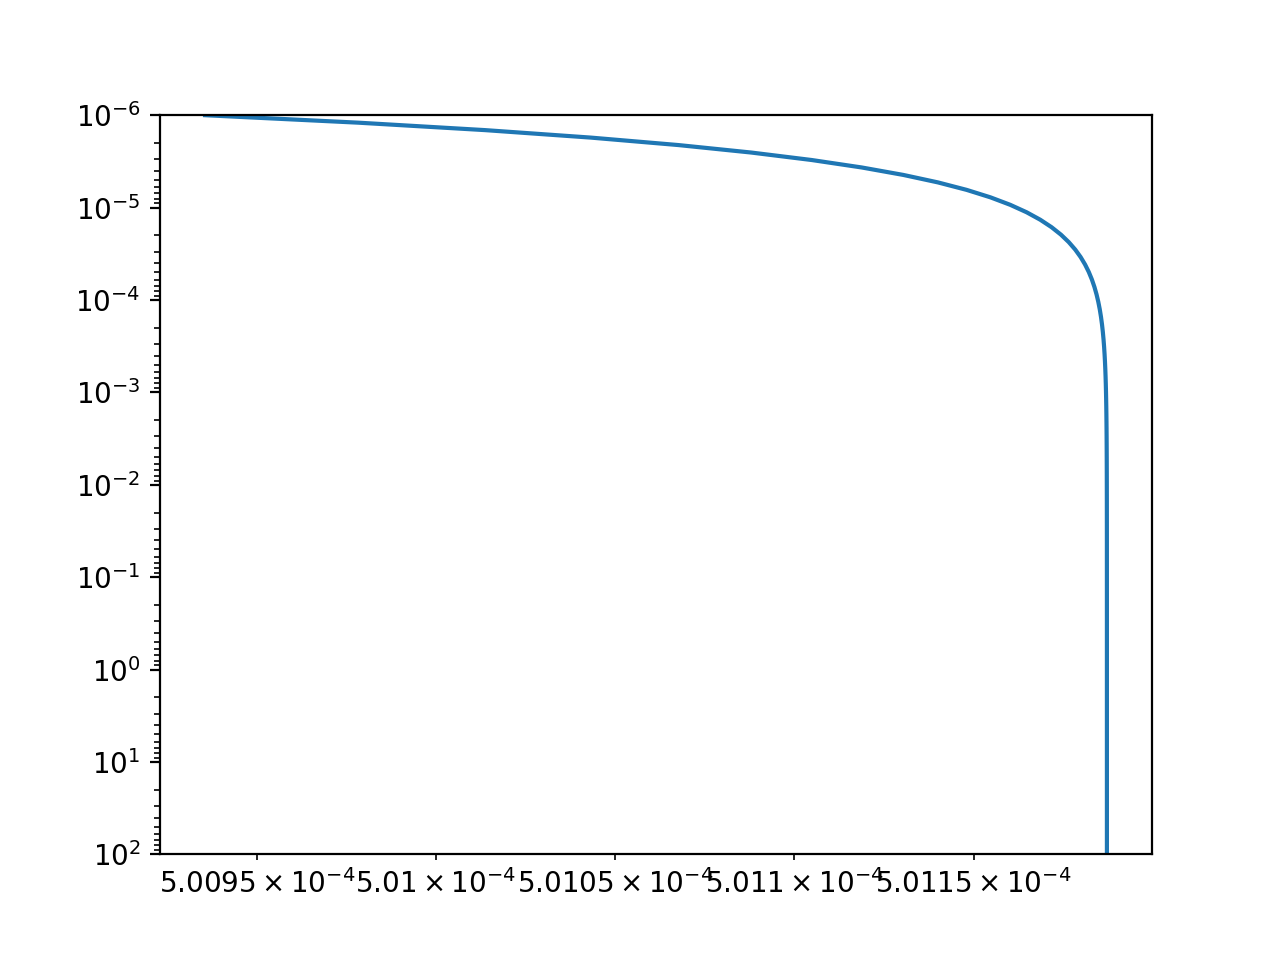

(100.0, 1e-06)

In [48]:
plt.figure()
plt.loglog(h2o,p)
plt.ylim(1e2,1e-6)
# plt.xlim(1e-12,1e0)